In [1]:
'''
https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
'''

import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [10]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

`time_series_covid19_confirmed_global.csv`
- Latitude/longitude, time series confirmed cases
- Country code not in this file.
- Some country strings are not standard like:  "Korea, South"

`API_EN.POP.DNST_DS2_en_csv_v2_988966.csv`
- Population density for 2019. The 2020 information is not there.

`covid-19-tests-vs-cases-positivity-comparisons.csv`
- Tests that came out positivve
- Missing a lot of numbers for how many tests were performed. We need to grab these numbers from `full-list-covid-19-tests-per-day.csv`


**Plan of action?**

- Are we planning to use the regions/province data? Or will we consolidate it into one country.
- Should we combined all the the fields we want into a single file?
- We need mapping of country codes to country names. Let’s pick one file that looks sane and use it. Then we have to map country names from `time_series_covid19_confirmed_global.csv` back to the correct code.
- We should normalize the start/end dates. We need to get the intersection of start/end dates for all files and only use that.

In [7]:
confirmed_cases = pd.read_csv("datasets/time_series_covid19_confirmed_global.csv")

print('Datasets:', confirmed_cases.shape)
confirmed_cases.head()

Datasets: (264, 96)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


In [8]:
confirmed_cases.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,...,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,21.317326,22.168315,2.102273,2.477273,3.564394,5.431818,8.022727,11.087121,21.128788,23.356061,...,7215.295455,7485.571970,7788.083333,8153.170455,8485.568182,8779.386364,9095.079545,9364.613636,9656.412879,9937.170455
std,24.734994,70.669996,27.382118,27.480921,34.210982,47.612615,66.537101,89.647535,220.011922,221.352587,...,40763.518495,42450.795915,44263.148610,46362.495521,48389.901654,50329.621230,52089.315934,53671.774238,55416.146689,57124.533362
min,-51.796300,-135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,6.969250,-20.026050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.500000,40.750000,48.000000,48.750000,51.250000,55.000000,55.000000,59.250000,64.000000,64.500000
50%,23.488100,20.535638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,294.500000,304.000000,319.000000,331.500000,335.000000,339.000000,341.500000,343.500000,352.500000,357.000000
75%,41.166075,78.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1352.000000,1379.750000,1407.500000,1533.250000,1575.500000,1615.750000,1654.250000,1678.500000,1737.500000,1787.500000
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,580619.000000,607670.000000,636350.000000,667592.000000,699706.000000,732197.000000,758809.000000,784326.000000,812036.000000,839675.000000


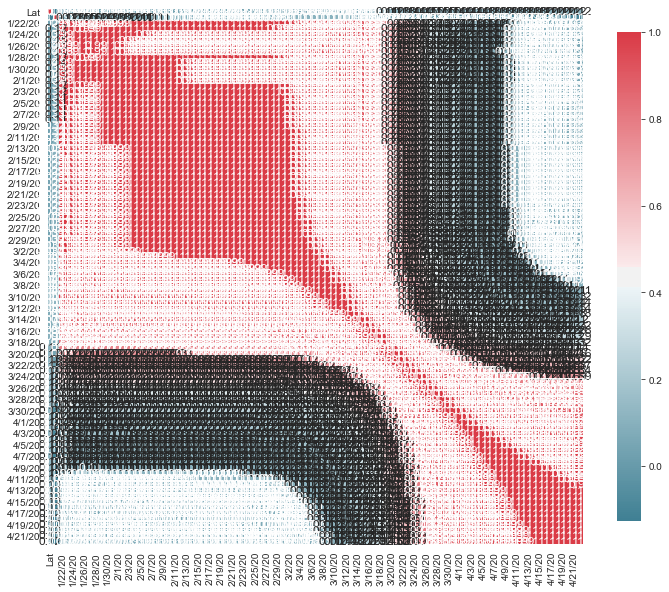

In [11]:
plot_correlation_map(confirmed_cases)